In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from sequana.somy import SomyScore
from sequana import GFF3
import seaborn as sns
import shutil
import pandas as pd
from collections import defaultdict

from matplotlib import rcParams
from pylab import savefig, xlim, ylim
rcParams['figure.figsize'] = (12,7)


OUTPATH = "images_and_results/"

# hybrid case

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:10<00:00, 20.09it/s]


Estimate mu: 69.0
Error: 29.05188980465116


(0.0, 5.0)

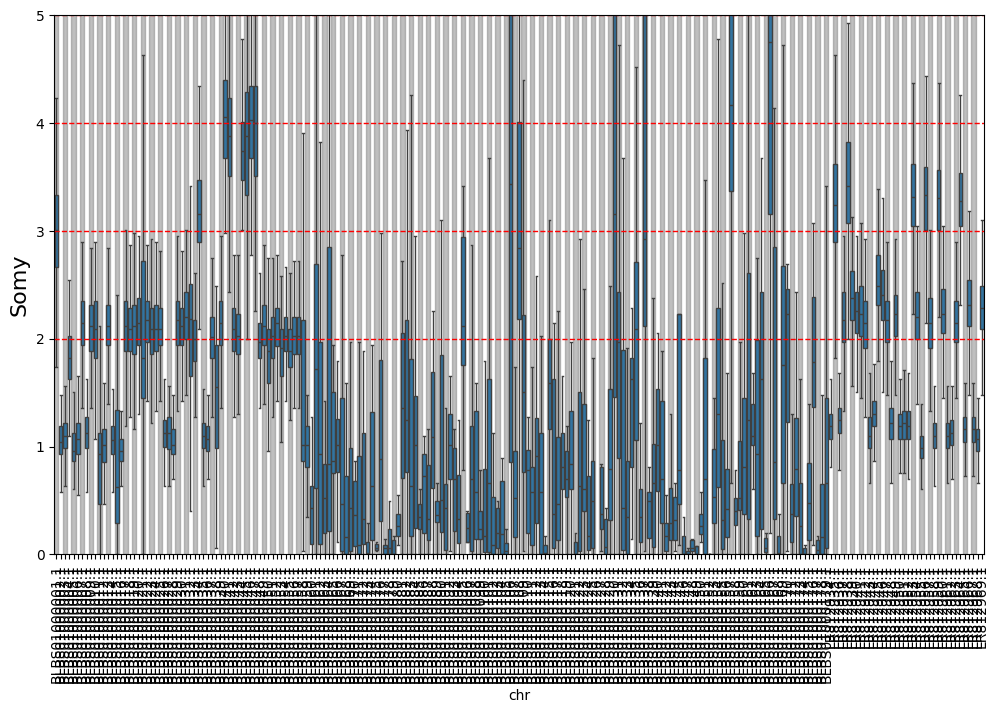

In [46]:
ss = SomyScore("data/BAMs/hyb_on_hyb.sorted.bam")
ss.compute_coverage()
ss.boxplot(method="median", hybrid=True)
ylim([0,5])


Here, lots of contigs in tarentolae that should be cleaned. we remove the small ones that are not associated with a chromosome name; 
we also rename the Infatum and Tarentolae chrom names as 1..36

In [47]:

g = GFF3("references/tarentolae.gff")
mapper = {}
for x in range(179):
    df = g.df.query("genetic_type=='region'")
    Name = df.iloc[x].Name
    if pd.isna(Name):
        mapper[df.iloc[x].seqid] = 0
    else:
        mapper[df.iloc[x].seqid] = int(Name)

g = GFF3("references/infantum.gff")
names = g.df.query("genetic_type=='region'").seqid.values
chrnames = list(range(1,36+1))
for i,name in enumerate(names):
    mapper[name] = i+1


# filter out contig not in chromosomes
valid_ctgs = [k for k,v in mapper.items() if v] + list(names)
ss._df = ss.df.query("chr in @valid_ctgs")
# add name
ss._df['name'] = [int(mapper[x]) for x in ss.df['chr'].values]
# add tag for boxplot
ss._df['tag'] = ['tar' if x.startswith('BL') else 'inf' for x in ss.df['chr']]
# rename chromosomes
ss._df['chr'] = [int(mapper[x]) for x in ss._df['chr'].values]


Estimate mu: 70.0
Error: 0.027738791666666665


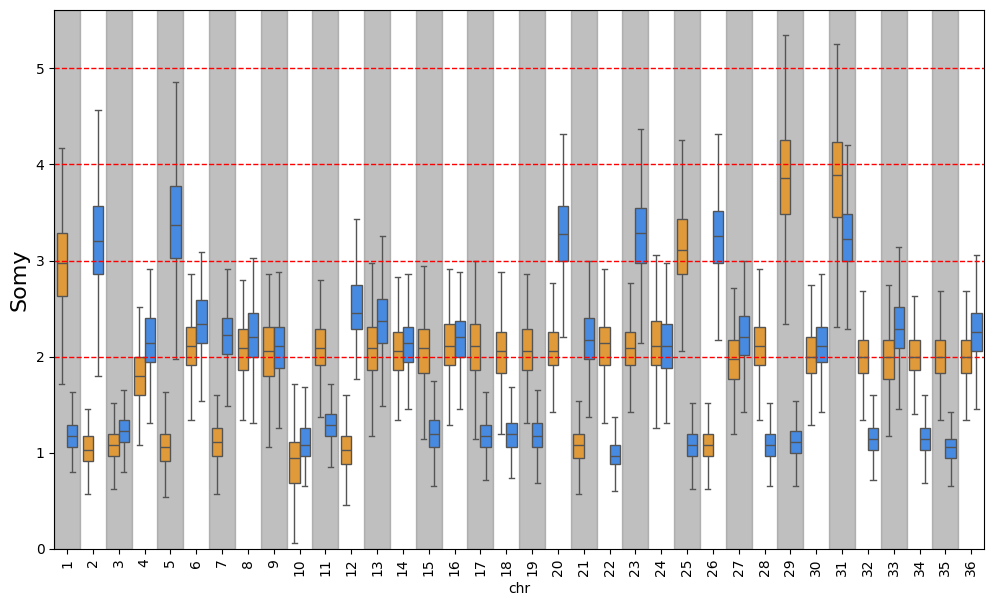

In [48]:
ss.boxplot(method="median", hybrid=True, palette=["#fc9f1d", "#2d87fc"])
ss.somies.to_csv(f"{OUTPATH}/somies_hyb.csv", index=None)
from pylab import legend
savefig(f"{OUTPATH}/final_hybrid_somy.png", dpi=200)


# tarentolae on tarentolae

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:09<00:00, 19.46it/s]


Estimate mu: 154.0
Error: 0.00952502777777778


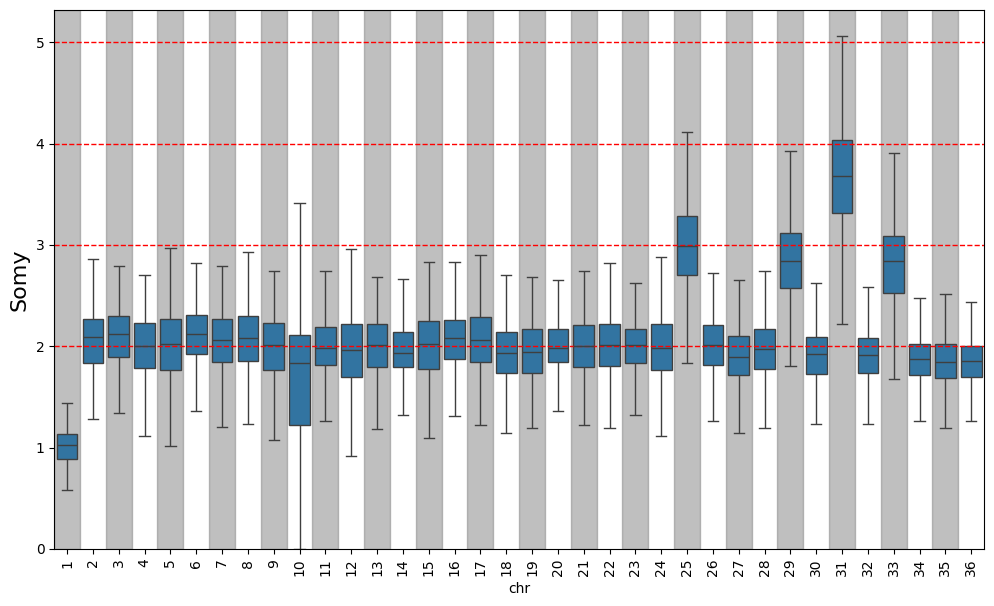

In [49]:


ss = SomyScore("data/BAMs/tar_on_tar.sorted.bam")
ss.compute_coverage()
ss._df['chr'] = [int(mapper[x]) for x in ss._df['chr'].values]
ss._df = ss._df.query("chr!=0")
ss.boxplot(method="median", hybrid=True)
ss.somies.to_csv(f"{OUTPATH}/somies_tar.csv", index=None)
savefig(f"{OUTPATH}/tar_somy.png", dpi=200)



# infantum on infantum

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:06<00:00,  5.50it/s]


Estimate mu: 151.0
Error: 0.021332416666666656


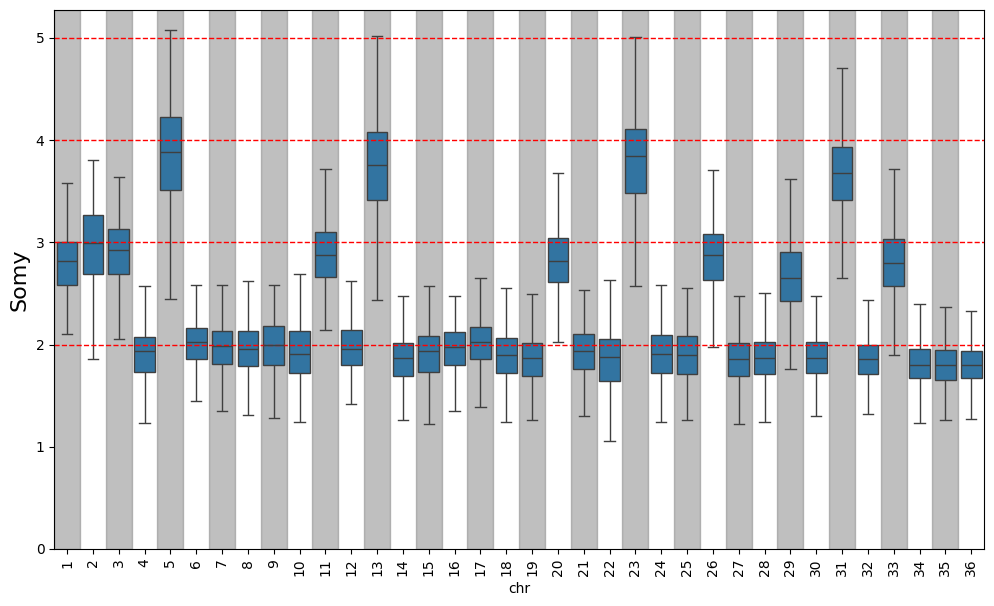

In [50]:
ss = SomyScore("data/BAMs/inf_on_inf.sorted.bam")
ss.compute_coverage()
ss._df['chr'] = [int(mapper[x]) for x in ss._df['chr'].values]
ss.boxplot(method="median", hybrid=True)
ss.somies.to_csv(f"{OUTPATH}/somies_inf.csv", index=None)
savefig(f"{OUTPATH}/inf_somy.png", dpi=200)



# relation somies infantum parent versus tarentolae parent is random

Slope: 0.42647058823529393
Intercept: 1.544117647058824
R-squared: 0.08136609907120734


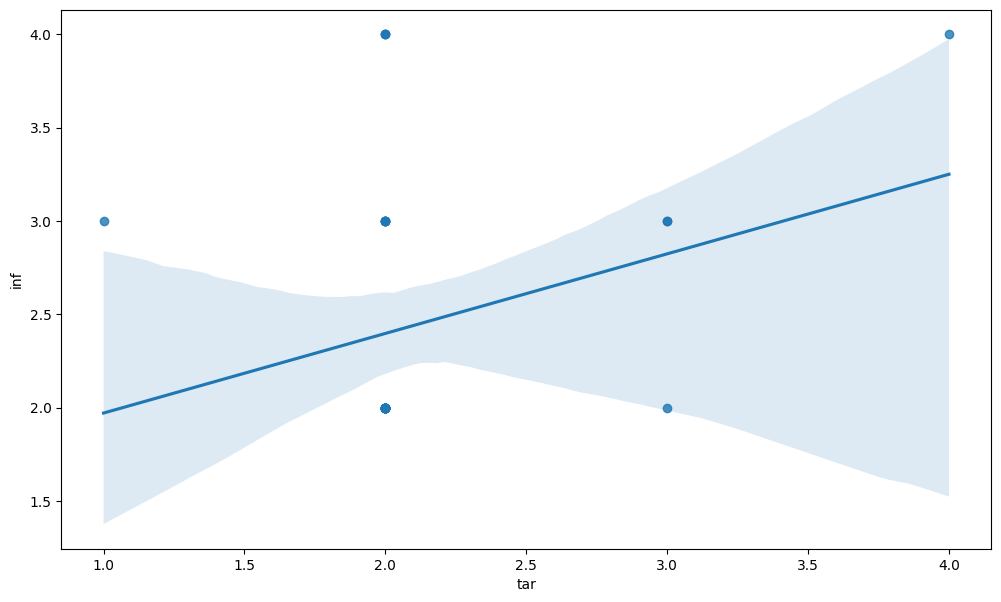

In [41]:
from scipy import stats
import seaborn as sns

X=pd.read_csv(f"{OUTPATH}/somies_tar.csv")["estimated_somies"].values
Y=pd.read_csv(f"{OUTPATH}/somies_inf.csv")["estimated_somies"].values
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)


data_regression = pd.DataFrame({'tar': X, 'inf': Y})
sns.regplot(x="tar", y="inf", data=data_regression, x_jitter=0.0);

# Print results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# relation somies infantum versus tarentolae within hybrid

[3 1 1 2 1 2 1 2 2 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2 3 1 2 2 4 2 4 2 2 2 2 2]
Slope: -0.19565217391304354
Intercept: 2.130434782608696
R-squared: 0.03652173913043478


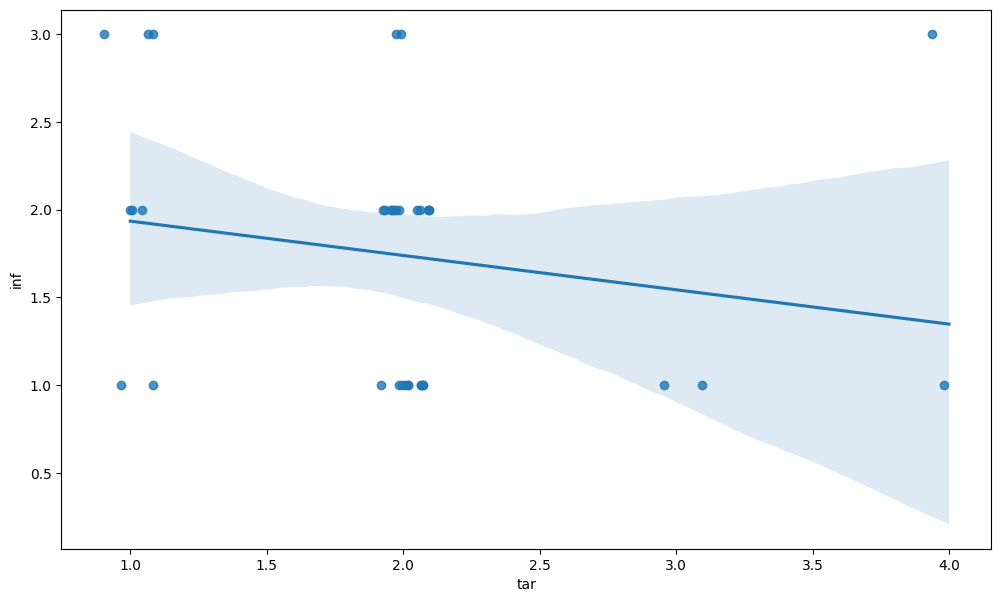

In [42]:
X = pd.read_csv(f"{OUTPATH}/somies_hyb.csv").query("tag=='tar'")["estimated_somies"].values
Y = pd.read_csv(f"{OUTPATH}/somies_hyb.csv").query("tag=='inf'")["estimated_somies"].values
print(X)
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)


data_regression = pd.DataFrame({'tar': X, 'inf': Y})
sns.regplot(x="tar", y="inf", data=data_regression, x_jitter=0.1);

# Print results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Distribution of somies is not symetric

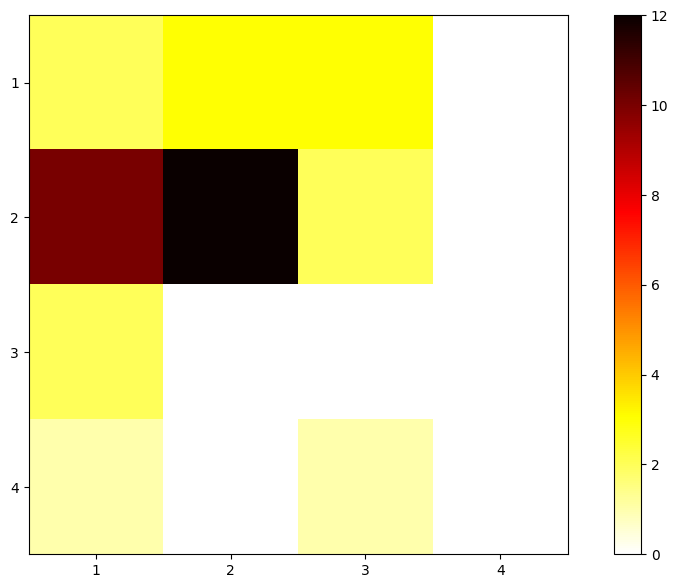

In [43]:
import numpy as np
from pylab import *
somies = np.zeros((4,4))
for x, y in zip(X, Y):
    somies[x-1,y-1] +=1
imshow(somies, cmap="hot_r")
xticks(range(0,4), range(1,5))
yticks(range(0,4), range(1,5))
colorbar()